# Task 3d Solution

--- In this example you will learn to approproately combine (stack) different images

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
save = False

--- combine (stack) a list of images together

In [3]:
image_dir = 'data' # image directory relative to this script

In [4]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask

In [5]:
filters = ['f435w','f606w', 'f775w','f850lp', 'f105w','f125w','f140w','f160w']
detection_filters = ['f105w','f125w','f140w','f160w'] # list of images to combine (stack)

In [6]:
sci = {f: fits.getdata(f'{image_dir}/{f}_sci.fits') for f in filters} # read sci images
wht = {f: fits.getdata(f'{image_dir}/{f}_wht.fits') for f in filters} # read weight images

In [7]:
shape = next(iter(sci.values())).shape
combined_sci = np.zeros(shape)
combined_wht = np.zeros(shape)

In [8]:
for f in detection_filters:
    combined_sci += sci[f]*wht[f]
    combined_wht += wht[f]

In [9]:
combined_sci /= combined_wht

<ipython-input-9-bec522ab799b>:1: RuntimeWarning: invalid value encountered in true_divide
  combined_sci /= combined_wht


--- cut out a portion of the image for analysis

In [10]:
x = 3100                # pixel x-centre of cutout, must be an integer
y = 1800                # pixel y-centre of cutout, must be an integer
r = 200

In [11]:
combined_sci = combined_sci[x-r:x+r, y-r:y+r] # cutout a portion of the science image
combined_wht = combined_wht[x-r:x+r, y-r:y+r] # cutout a portion of the weight image

In [12]:
print(combined_sci.shape)

(400, 400)


--- define the noise in each pixel and make a significance map (signal/noise)

In [13]:
noise = 1./np.sqrt(combined_wht) # conversion from weight to noise
sig = combined_sci/noise # significance map

--- now run segmentation on the image. Segmentation identifies groups of connected pixels which are all above some threshold.

In [14]:
from photutils import detect_sources

In [15]:
threshold = 2.5 # require each pixel have a significance of >2.5 (since we're using the significance image)
npixels = 5 # require at least 5 connected pixels

In [16]:
segm = detect_sources(sig, threshold, npixels=npixels) # make segmentation image

In [17]:
i = 83 # this corresponds to the object we found in the previous task 3b

In [18]:
slices = segm.slices[i-1] # a pair of python slice objects NOTE: the -1 is necessary as slices are only provided for objects not the background. The first object would be segm.slices[0] NOT segm.slices[1] because of python indexing convention. BE CAREFUL.

setting the RGB filters

In [19]:
f_RGB = {'R': ['f105w', 'f125w', 'f140w', 'f160w'] , 'G': ['f775w','f850lp'], 'B': ['f435w', 'f606w']} # define the images corresponding to the RGB channels

cutting the images

In [20]:
for f in filters:
    sci[f] = sci[f][x-r:x+r, y-r:y+r]
    wht[f] = wht[f][x-r:x+r, y-r:y+r]

In [21]:
im_rgb = {'R': np.zeros(sci['f160w'].shape), 'G': np.zeros(sci['f160w'].shape), 'B': np.zeros(sci['f160w'].shape)}

In [22]:
from matplotlib import cm

In [23]:
for band in 'RGB':
    combined_wht = 0.
    for f in f_RGB[band]:
        im_rgb[band] += sci[f]*wht[f]
        combined_wht += wht[f]
    im_rgb[band] /= combined_wht
    vmin = 0 # exclude negative values (anything less than vmin gets mapped to vmin)
    vmax =  np.percentile(im_rgb[band][~np.isnan(im_rgb[band])], 99) # exclude the brightest 1% of pixels (anything above gets mapped to that value)
    norm = cm.colors.Normalize(vmin, vmax) # normalisation function
    im_rgb[band] = norm(im_rgb[band]) # apply normalisation function
    norm = np.NaN

    # --- set masked values to zero
    im_rgb[band] = np.ma.filled(im_rgb[band], 0.0) # return masked array with masked values set to 0.0 (this makes those pixels black)

In [24]:
rgb = np.dstack((im_rgb['R'],im_rgb['G'],im_rgb['B'])) # stack images into a single array

In [25]:
import matplotlib.pyplot as plt

In [26]:
plot_filters = ['RGB', 'f435w','f606w', 'f775w','f850lp', 'f105w','f125w','f140w','f160w']

In [27]:
n = len(plot_filters)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


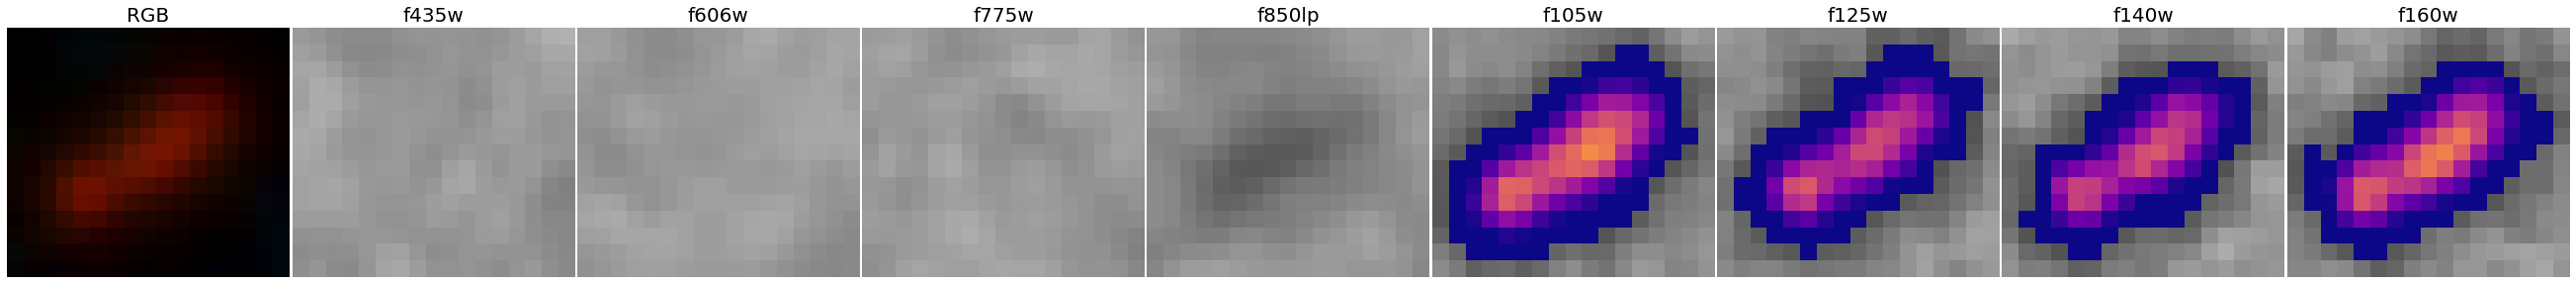

In [28]:
fig, axes = plt.subplots(1, n, figsize = (4*n,4))
plt.subplots_adjust(left=0, top=0.95, bottom=0, right=1, wspace=0.01, hspace=0.01)

for ax, filter in zip(axes, plot_filters):
    if filter == 'RGB':
        ax.set_axis_off()
        ax.imshow(rgb[slices], origin='lower')
        ax.set_title(filter, size=20)
    else:
        noise = 1/np.sqrt(wht[filter][slices])
        sig = (sci[filter][slices]/noise)
        ax.set_axis_off()
        ax.imshow(sig, cmap = cm.Greys, vmin = -5.0, vmax = 5.0, origin = 'lower')
        ax.imshow(np.ma.masked_where(sig <= threshold, sig), cmap = cm.plasma, vmin = 5, vmax = 20, origin = 'lower')
        ax.set_title(filter, size=20)
        
plt.savefig('figures/stamps.png')
plt.show()